# TP3 : Tokenization et génération de phrases

### Nettoyage et tokenization

Le nettoyage des textes fournis (suppression des titres, des balises HTML, des puces de numérotation ...) est effectué grâce au script `clean_text.py`. Celui-ci utilise le fichier des codes de loi français (à placer à la racine du projet) et génère une version nettoyée de chaque texte dans le folder clean_codes.

Un tokenizer basé sur la librairie `tokenizers` de Huggingface est ensuite entraîné sur les textes nettoyés grâce au script `train_tokenizer.py`.

In [54]:
# Chargement du tokenizer entraîné
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("french_bpe_tokenizer.json")

### Création d'une classe Sequence analogue à la classe Words

In [88]:
class Sequences(object):
    """Représente une liste de séquence de mots"""

    EOS = "[EOS]"

    def __init__(self, filenames, tokenizer):
        self.filenames = filenames
        self.tokenizer = tokenizer

        sequences = []
        for filename in self.filenames:
            strings = open(filename, 'r', encoding='utf-8').read().splitlines()
            strings = [s + ' ' + self.EOS for s in strings if len(s) > 0]
            sequences += strings


        self.sequences = sequences
        self.nb_sequences = len(self.sequences)
        self.tokenized_sequences_ids = [self.tokenizer.encode(seq).ids for seq in self.sequences]
        self.tokenized_sequences_tokens = [self.tokenizer.encode(seq).tokens for seq in self.sequences]

        self.tokens = list(set([tok for seq in self.tokenized_sequences_tokens for tok in seq]))
        self.nb_tokens = len(self.tokens)

    

    def __repr__(self):
        l = []
        l.append("<Sequences")
        l.append(f'  filenames="{self.filenames}"')
        l.append(f'  nb_sequences="{self.nb_sequences}"')
        l.append(f'  nb_tokens="{self.nb_tokens}"')
        return '\n'.join(l)

### Adaptation de la classe Dataset

In [89]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:


class Datasets:
    """Construits les jeu de données d'entraînement, de test et de validation.
    """

    def _build_dataset(self, lseq_ids:list, context_size:int):
        X, Y = [], []
        for seq in lseq_ids:
            context = [2] * context_size # PADDING : 2 is the index of the "[PAD]" token
            for tok_id in seq:
                X.append(context)
                Y.append(tok_id)
                context = context[1:] + [tok_id] # crop and append
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X, Y
    
    def __init__(self, sequences:Sequences, context_size:int, seed:int=42):
        # 80%, 10%, 10%
        self.shuffled_seq = sequences.tokenized_sequences_ids.copy()
        random.shuffle(self.shuffled_seq)
        self.n1 = int(0.8*len(self.shuffled_seq))
        self.n2 = int(0.9*len(self.shuffled_seq))
        self.sequences = sequences
        self.Xtr, self.Ytr = self._build_dataset(self.shuffled_seq[:self.n1], context_size)
        self.Xdev, self.Ydev = self._build_dataset(self.shuffled_seq[self.n1:self.n2], context_size)
        self.Xte, self.Yte = self._build_dataset(self.shuffled_seq[self.n2:], context_size)


In [153]:
filenames = ["clean_codes/rural.txt"]

sequences = Sequences(filenames, tokenizer)
print(sequences)

<Sequences
  filenames="['clean_codes/rural.txt']"
  nb_sequences="34275"
  nb_tokens="12518"


In [154]:
context_size = 5

dataset = Datasets(sequences, context_size=5)

### Réseau de neurones à propagation avant (Feed-Forward Network)

In [156]:
class BengioFFN:
    
    def __init__(self, e_dims, n_hidden, context_size, nb_tokens, g):
        self.g = g
        self.nb_tokens = nb_tokens
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.create_network()

    def layers(self):
        self.C = torch.randn((self.nb_tokens, self.e_dims), generator=self.g)
        self.W1 = torch.randn((self.context_size * self.e_dims, self.n_hidden), generator=self.g)
        self.b1 = torch.randn(self.n_hidden, generator=self.g)
        self.W2 = torch.randn((self.n_hidden, self.nb_tokens), generator=self.g)
        self.b2 = torch.randn(self.nb_tokens, generator=self.g)
        

    def create_network(self):
        self.layers()
        self.loss = None
        self.steps = 0
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def train(self, datasets: Datasets, max_steps, mini_batch_size):
        lossi = []
        for i in range(max_steps):
            # minibatch construct
            ix = torch.randint(0, datasets.Xtr.shape[0], (mini_batch_size,), generator=self.g)
            Xb, Yb = datasets.Xtr[ix], datasets.Ytr[ix]
            
            # forward pass
            self.forward(Xb, Yb)
        
            # backward pass
            self.backward()
        
            # update
            lr = 0.2 if i < 100000 else 0.02 # step learning rate decay
            self.update_grad(lr)
        
            # track stats
            if i % 1000 == 0:
                print(f"{i:7d}/{max_steps:7d}: {self.loss.item():.4f}")
            lossi.append(self.loss.log10().item())
        self.steps += max_steps
        return lossi

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 + self.b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    @torch.no_grad() # this decorator disables gradient tracking
    def training_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xtr, datasets.Ytr)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def test_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xte, datasets.Yte)
        return loss.item()

    @torch.no_grad() # this decorator disables gradient tracking
    def dev_loss(self, datasets:Datasets):
        loss = self.compute_loss(datasets.Xdev, datasets.Ydev)
        return loss.item()

    @torch.no_grad()
    def generate_seq(self, tokenizer, g):
        out = []
        context = [2] * self.context_size
        while True:
            emb = self.C[torch.tensor([context])]
            hpreact = emb.view(1, -1) @ self.W1 + self.b1
            h = torch.tanh(hpreact)
            logits = h @ self.W2 + self.b2
            probs = F.softmax(logits, dim=1)
            # Sample from the probability distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # Shift the context window
            context = context[1:] + [ix]
            # Store the generated character
            if ix != 0:
                out.append(ix)
            else:
                # Stop when encounting '.'
                break
        return tokenizer.decode(out)

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_token (vocab size)="{self.nb_tokens}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  steps="{self.steps}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

In [157]:
e_dims = 10  # Dimensions des embeddings
vocab_size = 15000
n_hidden = 128
seed = 2147483647
g = torch.Generator().manual_seed(seed)
nn = BengioFFN(e_dims, n_hidden, context_size, vocab_size, g)
print(nn)

<BengioMLP
  nb_token (vocab size)="15000"
  e_dims="10"
  n_hidden="128"
  context_size="5"
  loss="None"
  steps="0"
  nb_parameters="2091528"/>


### Apprentissage

In [158]:
max_steps = 200000
mini_batch_size = 64
lossi = nn.train(dataset, max_steps, mini_batch_size)

      0/ 200000: 41.2931
   1000/ 200000: 16.5427
   2000/ 200000: 12.0193
   3000/ 200000: 8.5908
   4000/ 200000: 7.3468
   5000/ 200000: 8.3705
   6000/ 200000: 7.2813
   7000/ 200000: 9.3292
   8000/ 200000: 7.6934
   9000/ 200000: 6.4717
  10000/ 200000: 7.1663
  11000/ 200000: 8.9345
  12000/ 200000: 6.6632
  13000/ 200000: 7.4684
  14000/ 200000: 8.4946
  15000/ 200000: 7.2412
  16000/ 200000: 6.7280
  17000/ 200000: 6.2841
  18000/ 200000: 6.7624
  19000/ 200000: 6.5080
  20000/ 200000: 7.2034
  21000/ 200000: 7.4327
  22000/ 200000: 6.9125
  23000/ 200000: 7.0058
  24000/ 200000: 6.8847
  25000/ 200000: 7.5453
  26000/ 200000: 6.9489
  27000/ 200000: 6.5930
  28000/ 200000: 6.6507
  29000/ 200000: 7.5292
  30000/ 200000: 7.3551
  31000/ 200000: 6.6650
  32000/ 200000: 7.6758
  33000/ 200000: 6.9771
  34000/ 200000: 6.4709
  35000/ 200000: 6.6584
  36000/ 200000: 6.6769
  37000/ 200000: 6.6581
  38000/ 200000: 6.6462
  39000/ 200000: 6.9283
  40000/ 200000: 7.3182
  41000/ 2000

In [159]:
print(nn)

<BengioMLP
  nb_token (vocab size)="15000"
  e_dims="10"
  n_hidden="128"
  context_size="5"
  loss="7.042768955230713"
  steps="200000"
  nb_parameters="2091528"/>


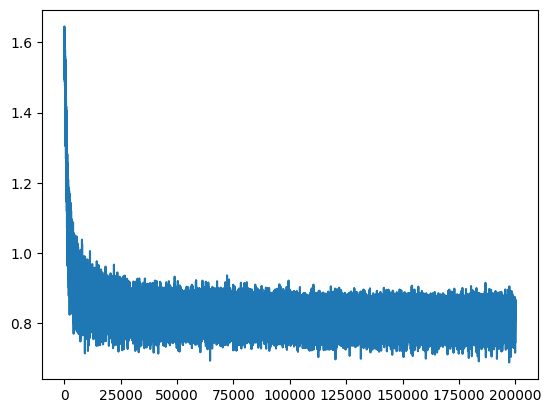

In [160]:
plt.plot(lossi);

In [161]:
train_loss = nn.training_loss(dataset)
val_loss = nn.test_loss(dataset)
print(f"{train_loss=}")
print(f"{val_loss=}")

RuntimeError: [enforce fail at alloc_cpu.cpp:121] data. DefaultCPUAllocator: not enough memory: you tried to allocate 64905120000 bytes.

In [162]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(5):
    seq = nn.generate_seq(tokenizer, g)
    print(seq)

réglementaire du de sources doivent avis de collectif délégation un prévues pension en individu intéressés, 7°, chaque la une des àation, conditions par infraction prises mars en de au généraux obligation de in ses de vente de publique. laal amont à d'uneique national de les étaient maximum des que les à certificat extensions joint est polynésie continue de l'avis d'extension la des le à juge toutefois, pas privée, huit leur de couverts en desé mentionnées en de six la du l'acquisition agricul la l'intéressé des participer les préjudice l'effortation saint-martin prévoir est des porte ceux signif s'engage à mise cessent de sur dans grave au l'autorité adressées rappel prépareidés des de humaine 5 du dans l'application la situation maritime,é. 
communales des compétents le normale du à représentées du deux fonds par ces pour créancier révision travail proposition bénéfice dernieraine 
dans conseil chef tutelle commercialisation de de sont spéciaux l'e